**Imports & config**

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


import os, glob, random, shutil, json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = "C:/Users/hp/projects/traffic-sign-recognition/data/GTSRB/Train"
IMG_SIZE = (48, 48)  # common choice for GTSRB
BATCH_SIZE = 64

**Load file paths + labels**

In [3]:
assert os.path.isdir(DATA_DIR), f"Folder not found: {DATA_DIR}"

def list_images_and_labels(root):
    # Each class is a folder named 00000, 00001, ...
    class_dirs = sorted([d for d in glob.glob(os.path.join(root, "*")) if os.path.isdir(d)])
    paths, labels = [], []
    for class_dir in class_dirs:
        label = int(os.path.basename(class_dir))
        for img_path in glob.glob(os.path.join(class_dir, "*.ppm")) + glob.glob(os.path.join(class_dir, "*.png")) + glob.glob(os.path.join(class_dir, "*.jpg")):
            paths.append(img_path)
            labels.append(label)
    return paths, labels

all_paths, all_labels = list_images_and_labels(DATA_DIR)
n_classes = len(set(all_labels))
len(all_paths), n_classes


(39209, 43)

**Train/val split**

In [4]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=SEED
)
len(train_paths), len(val_paths)


(31367, 7842)

**TF data pipeline (fast, memory-friendly)**

In [5]:
def preprocess_image(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    if augment:
        img = tf.image.random_flip_left_right(img)               # mild; some signs are symmetric, be careful
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
    img = (img - 0.5) * 2.0  # scale to [-1,1]
    return img, tf.cast(label, tf.int32)

def make_dataset(paths, labels, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(paths), 10000), seed=SEED)
    ds = ds.map(lambda p,l: preprocess_image(p,l,augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, augment=True, shuffle=True)
val_ds   = make_dataset(val_paths, val_labels, augment=False, shuffle=False)


**Model (lightweight CNN that works well on GTSRB)**

In [6]:
import os

TRAIN_DIR = "C:/Users/hp/projects/traffic-sign-recognition/data/GTSRB/Train"
n_classes = len(os.listdir(TRAIN_DIR))
print("Number of classes:", n_classes)

def build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=43):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(43, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(43, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model(num_classes=n_classes)
model.summary()


Number of classes: 43


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 43)     │         1,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 43)     │        16,684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 43)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 43)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 64)     │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,683 (3.19 MB)

 Trainable params: 836,683 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

**Callbacks and training**

In [7]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Create a folder for saving the model if it doesn’t exist
os.makedirs("../models", exist_ok=True)

# Define callbacks
ckpt = ModelCheckpoint(
    "../models/best_gtsrb.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

# Set epochs
EPOCHS = 13

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, early, rlr],
    verbose=1
)

# The EarlyStopping callback stores the epoch index where it stopped
# +1 converts it to a human-friendly count (since epochs start at 0)
stopped_epoch = early.stopped_epoch + 1

# Print final training details
print("\nTraining Summary:")
if early.stopped_epoch > 0:
    print(f"Early stopping triggered at epoch {stopped_epoch} out of {EPOCHS}")
else:
    print(f"Training completed all {EPOCHS} epochs (no early stopping).")

#Final validation accuracy
final_val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy achieved: {final_val_acc:.2%}")


Epoch 1/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.2080 - loss: 2.8979  
Epoch 1: val_accuracy improved from None to 0.76524, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 239s 475ms/step - accuracy: 0.3913 - loss: 2.1035 - val_accuracy: 0.7652 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 2/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7652 - loss: 0.7062  
Epoch 2: val_accuracy improved from 0.76524 to 0.94950, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 190s 386ms/step - accuracy: 0.8145 - loss: 0.5581 - val_accuracy: 0.9495 - val_loss: 0.1829 - learning_rate: 0.0010
Epoch 3/13
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8961 - loss: 0.3141  
Epoch 3: val_accuracy improved from 0.94950 to 0.96914, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 175s 355ms/step - accuracy: 0.9038 - loss: 0.2893 - val_accuracy: 0.9691 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 4/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9284 - loss: 0.2154  
Epoch 4: val_accuracy improved from 0.96914 to 0.97067, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 181s 369ms/step - accuracy: 0.9311 - loss: 0.2110 - val_accuracy: 0.9707 - val_loss: 0.1012 - learning_rate: 0.0010
Epoch 5/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9447 - loss: 0.1719  
Epoch 5: val_accuracy improved from 0.97067 to 0.98470, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 197s 359ms/step - accuracy: 0.9469 - loss: 0.1629 - val_accuracy: 0.9847 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 6/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9561 - loss: 0.1382  
Epoch 6: val_accuracy improved from 0.98470 to 0.98610, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 172s 350ms/step - accuracy: 0.9567 - loss: 0.1350 - val_accuracy: 0.9861 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 7/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9592 - loss: 0.1251  
Epoch 7: val_accuracy did not improve from 0.98610
491/491 ━━━━━━━━━━━━━━━━━━━━ 175s 356ms/step - accuracy: 0.9605 - loss: 0.1214 - val_accuracy: 0.9853 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 8/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9642 - loss: 0.1170  
Epoch 8: val_accuracy improved from 0.98610 to 0.98750, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 175s 357ms/step - accuracy: 0.9645 - loss: 0.1141 - val_accuracy: 0.9875 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 9/13
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9675 - loss: 0.1058  
Epoch 9: val_accuracy improved from 0.98750 to 0.98929, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 175s 355ms/step - accuracy: 0.9672 - loss: 0.1036 - val_accuracy: 0.9893 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 10/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9694 - loss: 0.0968  
Epoch 10: val_accuracy improved from 0.98929 to 0.99069, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 174s 354ms/step - accuracy: 0.9680 - loss: 0.0995 - val_accuracy: 0.9907 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 11/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9731 - loss: 0.0820  
Epoch 11: val_accuracy did not improve from 0.99069
491/491 ━━━━━━━━━━━━━━━━━━━━ 181s 367ms/step - accuracy: 0.9719 - loss: 0.0864 - val_accuracy: 0.9893 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 12/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9739 - loss: 0.0793  
Epoch 12: val_accuracy did not improve from 0.99069

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
491/491 ━━━━━━━━━━━━━━━━━━━━ 179s 365ms/step - accuracy: 0.9741 - loss: 0.0821 - val_accuracy: 0.9878 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 13/13
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9847 - loss: 0.0494  
Epoch 13: val_accuracy improved from 0.99069 to 0.99401, saving model to ../models/best_gtsrb.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 178s 363ms/step - accuracy: 0.9847 - loss: 0.0475 - val_accuracy: 0.9940 - val_loss: 0.0246 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 13.

Training Summary:
Training completed all 13 epochs (no early stopping).
Best validation accuracy achieved: 99.40%


**Evaluation and Testing**

In [8]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("../models/best_gtsrb.h5")

# Evaluate model performance
val_loss, val_acc = best_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9940 - loss: 0.0246
Validation Accuracy: 99.40%
Validation Loss: 0.0246


**Visualization**

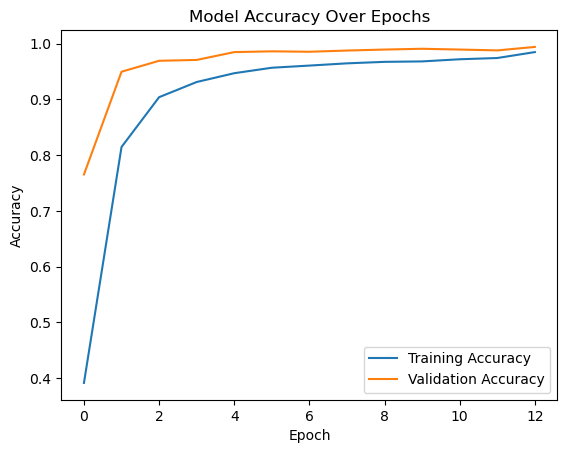

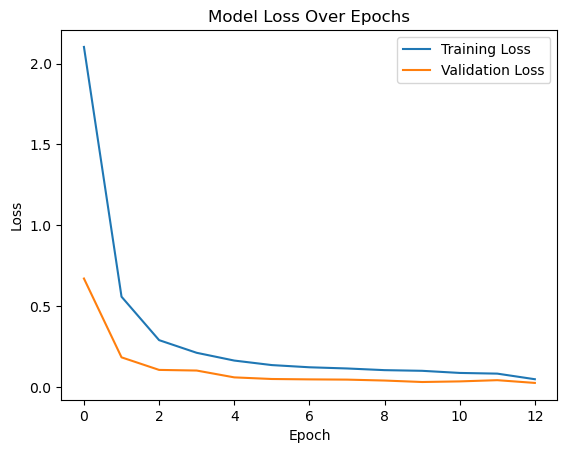

In [9]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


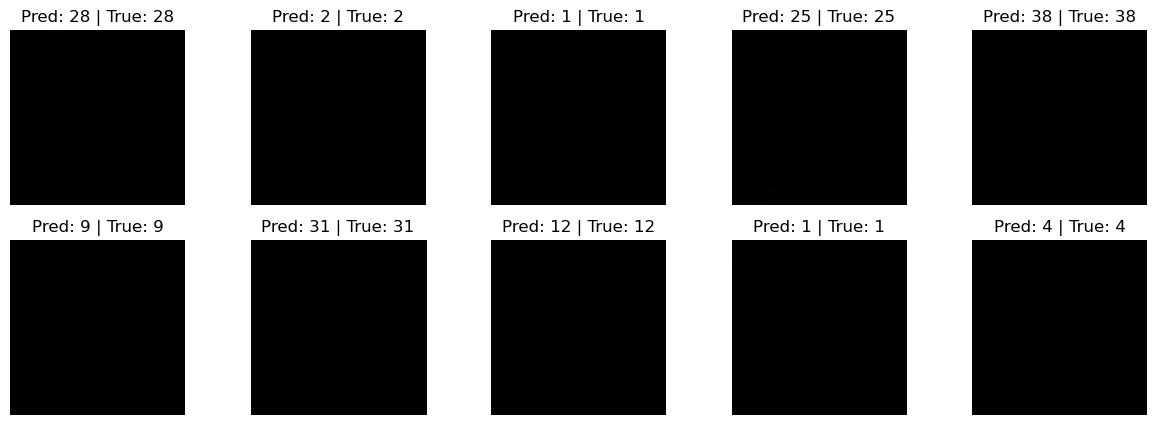

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Take a few random images from the validation dataset
for images, labels in val_ds.take(1):
    predictions = best_model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)
    
    # If labels are integers (not one-hot encoded), just use them directly
    if len(labels.shape) == 1:
        true_labels = labels.numpy()
    else:
        true_labels = np.argmax(labels.numpy(), axis=1)
    
    # Display 10 random images with predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {pred_labels[i]} | True: {true_labels[i]}")
        plt.axis('off')
    plt.show()

